In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 

from glob import glob
import sys 
import os

In [ ]:
outdir = '/ix/djishnu/shared/djishnu_kor11/perturbations/mLDN3-1_v4_Pax5'

adata_train = sc.read_h5ad(
    '/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4.h5ad')

adata_train

In [3]:
import celloracle as co 

oracle = co.load_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mLND3-1_v4.celloracle.oracle")
links = co.load_hdf5(file_path="/ix/djishnu/shared/djishnu_kor11/co_objects/mLND3-1_v4-links.celloracle.links")

In [4]:
from tqdm import tqdm 
from collections import defaultdict

class HackedOracle():

    def __init__(self, oracle):
        self.oracle = oracle
        self.adata = oracle.adata
        self.coef_matrix_per_cluster = oracle.coef_matrix_per_cluster
        self.cluster_column_name = oracle.cluster_column_name

        self.simulations = defaultdict(dict)
    
    def _do_simulation(self, coef_matrix, simulation_input, gem, n_propagation, cluster):
        delta_input = simulation_input - gem

        delta_simulated = delta_input.copy()
        for i in tqdm(range(n_propagation)):
            delta_simulated = delta_simulated.dot(coef_matrix)
            delta_simulated[delta_input != 0] = delta_input

            # gene expression cannot be negative. adjust delta values to make sure that gene expression are not netavive values.
            gem_tmp = gem + delta_simulated
            gem_tmp[gem_tmp<0] = 0
            delta_simulated = gem_tmp - gem

            self.simulations[i+1][cluster] = delta_simulated

        gem_simulated = gem + delta_simulated

        return gem_simulated
    
    def simulate_shift(self, perturb_condition, n_propagation=3):
        gem_imputed = self._adata_to_df(self.adata, "imputed_count")
        simulation_input = self._adata_to_df(self.adata, "simulation_input")
        for i in perturb_condition.keys():
            simulation_input[i] = perturb_condition[i]

        simulated = []
        cluster_info = self.adata.obs[self.cluster_column_name]
        for cluster in np.unique(cluster_info):

            coef_matrix = self.coef_matrix_per_cluster[cluster].copy()
            cells_in_the_cluster_bool = (cluster_info == cluster)
            simulation_input_ = simulation_input[cells_in_the_cluster_bool]
            gem_ = gem_imputed[cells_in_the_cluster_bool]

            simulated_in_the_cluster = self._do_simulation(
                                            coef_matrix=coef_matrix,
                                            simulation_input=simulation_input_,
                                            gem=gem_,
                                            n_propagation=n_propagation,
                                            cluster=cluster)

            simulated.append(simulated_in_the_cluster)
        gem_simulated = pd.concat(simulated, axis=0)
        gem_simulated = gem_simulated.reindex(gem_imputed.index)
    
    def _adata_to_df(self, adata, layer_name, transpose=False):
        """
        Extract an numpy array from adata and returns as pandas DataFrane with cell names and gene names.

        Args:
            adata (anndata): anndata

            layer_name (str): name of layer in anndata

            trabspose (bool) : if True, it returns transposed array.

        Returns:
            pandas.DataFrame: data frame (cells x genes (if transpose == False))
        """
        array = self._adata_to_matrix(adata, layer_name, transpose=False)
        df = pd.DataFrame(array, columns=adata.var.index.values, index=adata.obs.index.values)

        if transpose:
            df = df.transpose()
        return df

    def _adata_to_matrix(self, adata, layer_name, transpose=True):
        """
        Extract an numpy array from adata and returns as numpy matrix.

        Args:
            adata (anndata): anndata

            layer_name (str): name of layer in anndata

            trabspose (bool) : if True, it returns transposed array.

        Returns:
            2d numpy array: numpy array
        """
        if isinstance(adata.layers[layer_name], np.ndarray):
            matrix = adata.layers[layer_name].copy()
        else:
            matrix = adata.layers[layer_name].todense().A.copy()

        if transpose:
            matrix = matrix.transpose()

        return matrix.copy(order="C")


In [5]:
from tqdm import tqdm
import copy

# # CO enforces between 1-5 propagations
# co_sim_counts = {}
# for iter in tqdm(range(1, 5)):
#     oracle.simulate_shift(perturb_condition={'Pax5': 0}, n_propagation=iter)
#     sim_counts = copy.deepcopy(oracle.adata.layers['simulated_count'])
#     co_sim_counts[iter] = sim_counts

potato_head = HackedOracle(oracle)
potato_head.simulate_shift(
    perturb_condition={'Pax5': 0}, n_propagation=9)
co_sim_counts = potato_head.simulations

100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


In [6]:
counts = {}

for iter, counts_dict in co_sim_counts.items():
    counts_df = pd.concat(counts_dict.values())
    counts_df = counts_df.reindex(adata_train.obs_names)
    counts[iter] = counts_df

In [7]:
counts[0] = adata_train.layers['imputed_count']
counts = [counts[i] - counts[i-1] for i in range(1, 9)]
co_sim_changes = [abs(mtx).sum(axis=0) for mtx in counts]
co_sim_changes = np.array(co_sim_changes)

2025-02-17 20:09:50,974 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-17 20:09:51,013 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


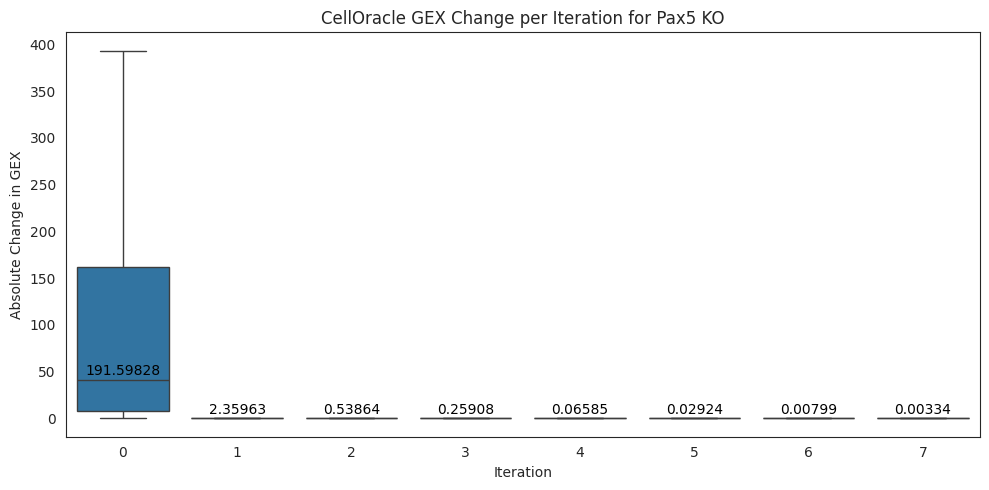

In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=co_sim_changes.T, ax=ax, showfliers=False)
mean_values = co_sim_changes.mean(axis=1)
median_values = np.median(co_sim_changes, axis=1)
for i, (median, mean) in enumerate(zip(median_values, mean_values)):
    ax.text(i, median + 1.5, f'{mean:.5f}', ha='center', va='bottom', color='black', 
            transform=ax.transData, clip_on=True, fontsize=10)

ax.set_xlabel('Iteration')
ax.set_ylabel('Absolute Change in GEX')
ax.set_title('CellOracle GEX Change per Iteration for Pax5 KO')
plt.tight_layout()
plt.show()

In [ ]:
gene_mtxes = glob(f'{outdir}/*.npy')
gex_dict = {0: adata_train.layers['imputed_count']}

for i, path in enumerate(sorted(gene_mtxes)):
    # gex_dict[i+1] = pd.read_parquet(path).values
    gex_dict[i+1] = np.load(path)

len(gex_dict)

In [ ]:
changes = [abs(gex_dict[k]).sum(axis=0) for k in range(len(gex_dict))]
changes = np.array(changes)
changes.shape

In [ ]:
changes[0].shape

In [ ]:
import seaborn as sns 
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=changes.T, ax=ax, showfliers=False)
mean_values = changes.mean(axis=1)
for i, mean in enumerate(mean_values):
    ax.text(i, mean+10, f'{mean:.2f}', ha='center', va='bottom', color='black', 
            transform=ax.transData, clip_on=True, fontsize=10)

ax.set_xlabel('Iteration')
ax.set_ylabel('Absolute Change in GEX')
ax.set_title('GEX Change per Iteration for Pax5 KO')
plt.tight_layout()
plt.show()